Import all the library we need for transfer learning

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pathlib
from tensorflow.keras import layers
import tensorflow_datasets as tfds

c:\Users\x2421\miniconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load image to "image_dir" from locol file 

In [2]:
#image_dir = []
#for i in range(1, 76):
#    s = ""
#    if i < 10:
#        s = "../dataImage/Acer/l2nr00" + str(i) + ".jpg"
#    else:
#        s = "../dataImage/Acer/l2nr0" + str(i) + ".jpg"
#    image_dir.append(tf.keras.utils.load_img(s))
    
#image_dir[0]


Other way to load images while dividing images into training and validation data

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(directory=
  "../dataImage",
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(256, 256),
  batch_size=32)

Found 1125 files belonging to 15 classes.
Using 788 files for training.


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "../dataImage",
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(256, 256),
  batch_size=32)

Found 1125 files belonging to 15 classes.
Using 337 files for validation.


In [5]:
#dataset = tf.keras.preprocessing.image_dataset_from_directory(
#    "dataImage",
#    image_size=(1683, 1683),
#    batch_size=32
#)

In [6]:
class_name = train_ds.class_names
class_name

['Acer',
 'Alnus incana',
 'Betula pubescens',
 'Fagus silvatica',
 'Populus',
 'Populus tremula',
 'Quercus',
 "Salix alba 'Sericea'",
 'Salix aurita',
 'Salix sinerea',
 'Sorbus aucuparia',
 'Sorbus intermedia',
 'Tilia',
 'Ulmus carpinifolia',
 'Ulmus glabra']

In [7]:
len(train_ds)

25

Print out some images from the batch to see whether the loaded images are correct.

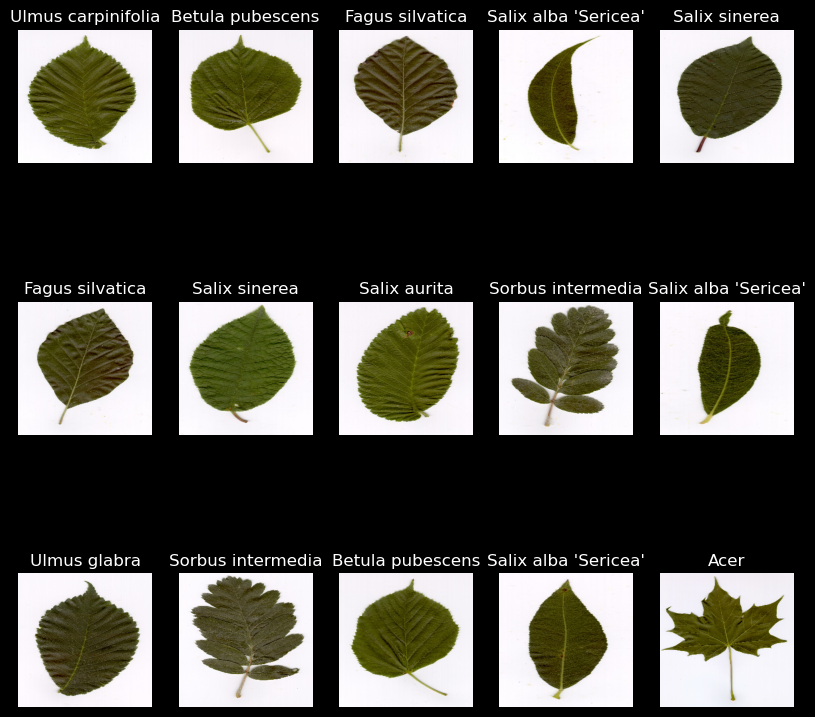

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in train_ds.take(1):
    for i in range(15):
        ax = plt.subplot(3,5,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[label_batch[i]])
        plt.axis("off")

Divide the validation dataset into two parts. One part goes to validation dataset and the other goes to test dataset

In [9]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches//5)
val_ds = val_ds.skip(val_batches//5)

In [10]:
print("Number of validation batches: %d" % tf.data.experimental.cardinality(val_ds))
print("Number of test batches: %d" % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 9
Number of test batches: 2


Increase the performance of the code

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
#test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Since we do not have sufficient data, we need data augmentation to get more data

In [12]:
data_augmentation = tf.keras.Sequential([
  #tf.keras.layers.Resizing(256, 256),
  tf.keras.layers.RandomRotation(0.3),
  tf.keras.layers.RandomZoom(0.1),
  tf.keras.layers.RandomFlip("horizontal")
  #tf.keras.layers.RandomFlip('horizontal'),
  #tf.keras.layers.RandomRotation(0.2),
])

Print out what images are like after augmentation

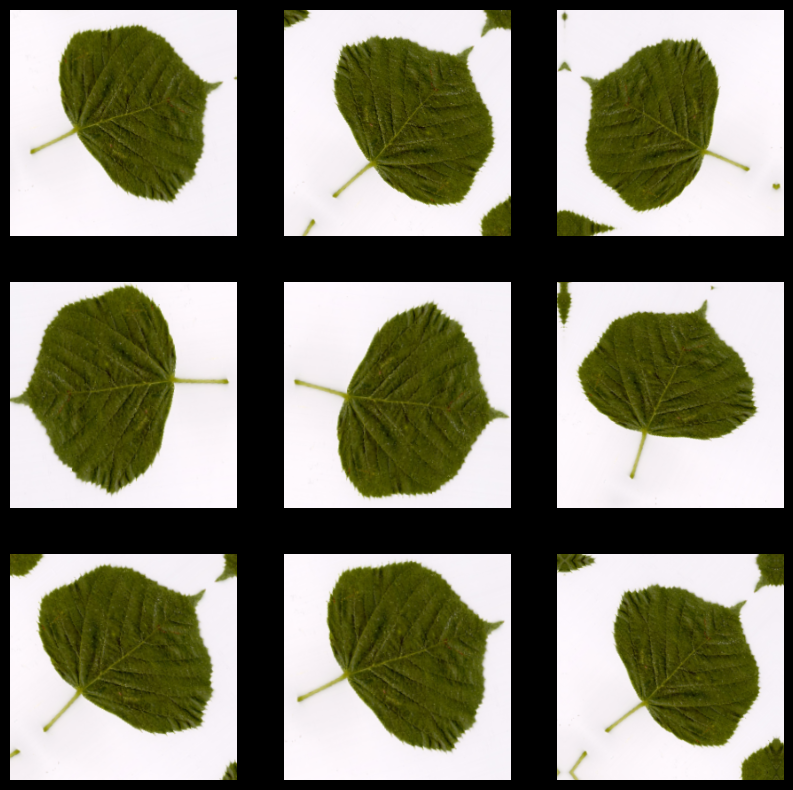

In [13]:
for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        #print("Min and max pixel values:", augmented_image.numpy().min(), augmented_image.numpy().max())
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [14]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [15]:
rescale = tf.keras.layers.Rescaling(1./255)

Create the base model from the pre-trained model VGG19

In [16]:

IMAGE_SIZE = (256, 256)
IMG_SHAPE = IMAGE_SIZE + (3,)
base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights="imagenet")

In [18]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 512)


In [19]:
base_model.trainable = False

Let's take a look at the base model architecture

In [20]:

base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [22]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Train models with train dataset

In [23]:
inputs = tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs) #input data not enough
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
print(inputs.__len__)

<bound method KerasTensor.__len__ of <KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_2')>>


In [24]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

The summary of the model

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0     

In [26]:
len(model.trainable_variables)

2

Test the accuracy of the model with validation dataset

In [27]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

9/9 [==============================] - 32s 3s/step - loss: -0.5515 - accuracy: 0.0916


In [28]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: -0.55
initial accuracy: 0.09


Let model to learn for 10 rounds.

In [29]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10


25/25 [==============================] - 3474s 144s/step - loss: -1.1724 - accuracy: 0.0711 - val_loss: -1.9301 - val_accuracy: 0.0769
Epoch 2/10
25/25 [==============================] - 111s 4s/step - loss: -2.5817 - accuracy: 0.0698 - val_loss: -3.0622 - val_accuracy: 0.1538
Epoch 3/10
25/25 [==============================] - 108s 4s/step - loss: -3.9539 - accuracy: 0.0761 - val_loss: -4.5286 - val_accuracy: 0.0733
Epoch 4/10
25/25 [==============================] - 109s 4s/step - loss: -5.4420 - accuracy: 0.0723 - val_loss: -5.5541 - val_accuracy: 0.0769
Epoch 5/10
25/25 [==============================] - 111s 4s/step - loss: -6.6940 - accuracy: 0.0685 - val_loss: -6.8283 - val_accuracy: 0.0696
Epoch 6/10
25/25 [==============================] - 110s 4s/step - loss: -7.9964 - accuracy: 0.0660 - val_loss: -8.2008 - val_accuracy: 0.0733
Epoch 7/10
25/25 [==============================] - 113s 5s/step - loss: -9.3866 - accuracy: 0.0635 - val_loss: -9.6368 - val_accuracy: 0.0696
Epoch 8

Print out the accuracy of the model and its learning curve.

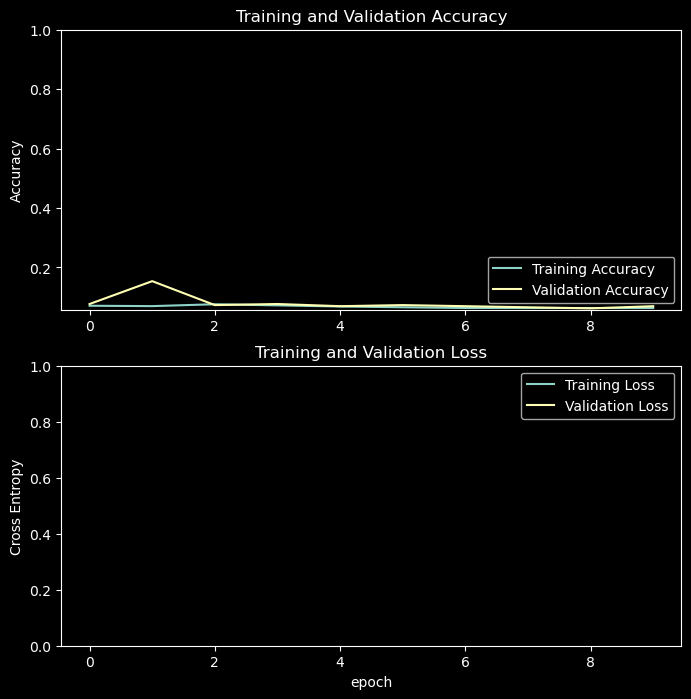

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()